# **Projeto de NLP para Classificação de Notícias em Português (BR)**

**Desenvolvimento do Projeto de Conclusão de Curso da Pós-Graduação BI-Master da PUC-Rio lecionada pelo Laboratório ICA.**

Objetivo do Projeto:
Testar a aplicação de alguns algoritmos para o Processamento de Linguagem Natural (NLP) a fim de classificar notícias em português (BR) com a melhor performance possível, segundo os seguintes assuntos: <br>

*   Economia
*   Esportes
*   Famosos
*   Política
*   Tecnologia




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import string
import unicodedata
import pickle

from keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics  import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm,metrics
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/'  # Inserir o local da pasta onde estão os arquivos de entrada
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
seed = 101
np.random.seed(seed)

## Definindo as funções a serem usadas no projeto

In [ ]:
#Função para "limpeza" dos textos
def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    s = re.sub(r"""\w*\d\w*""", ' ', s.lower())
    s = re.sub('[%s]' % re.escape(string.punctuation), ' ', s)
    symbols = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"
    s = s.replace(symbols,' ')
    s = s.replace('ç', 'c').replace('á', 'a').replace('â', 'a').replace('ã', 'a').replace('é', 'e').replace('ê', 'e').replace('í', 'i').replace('ô', 'o').replace('ó', 'o').replace('ú', 'u')
    return s

In [ ]:
#Função para remover emoji dos textos
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
#Função para criar as wordclouds
def wordcloud(text,assunto_list):
  text = text.to_string().lower()
  if assunto_list == []:
    category = 'Geral'
    wordcloud = WordCloud(collocations=False,
                          relative_scaling=0.5,
                          stopwords=set(stopwords.words('portuguese'))).generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.title(f'Wordcloud_{category}')
    plt.axis("off")
    plt.savefig(f'Wordcloud_{category}.png')
    plt.show()

  else:
    for category in assunto_list:
      text_category = text
      wordcloud = WordCloud(collocations=False,
                            relative_scaling=0.5,
                            stopwords=set(stopwords.words('portuguese'))).generate(text_category)

      plt.figure(figsize=(12,12))
      plt.imshow(wordcloud)
      plt.title(f'Wordcloud_{category}')
      plt.axis("off")
      plt.savefig(f'Wordcloud_{category}.png')
      plt.show()

In [ ]:
#Função para aplicar o modelo de classificação
def predict_model(classifier, 
                  train_features, train_labels, 
                  test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    
    return predictions 

In [ ]:
#Função para plotar a matriz de confusão
def plot_confusion_matrix(classificator_name, true_labels, predicted_labels, aux_df,column):
    
    conf_matrix = confusion_matrix(y_test, predicted_labels)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df[column].values, 
                yticklabels=aux_df[column].values,
                cmap="Blues")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title(f'Confusion Matrix - {classificator_name}')
    plt.savefig(f'Confusion Matrix_{classificator_name}.png')
    plt.show()

In [ ]:
#Função para gerar o report da classificação
def classification_report(true_labels, predicted_labels):
    
    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels) 
    print(report)

In [ ]:
#Função para printar as métricas de performance do modelo
def model_performance_metrics(true_labels, predicted_labels):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    classification_report(true_labels=true_labels, predicted_labels=predicted_labels)

In [ ]:
#Função para gerar métricas do modelo
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


In [ ]:
#Função para salvar o modelo selecionado
def model_save(model, model_name):
  filename = f'final_model_{model_name}.sav'
  pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Função para carregar o modelo selecionado
def load_model(model_name):
  filename = f'final_model_{model_name}.sav'
  model = pickle.load(open(filename, 'rb'))
  return (model)

In [ ]:
#Dicionario para converter as classes
dict_classes={
    'economia':0,
    'esportes':1,
    'politica':2,
    'famosos':3,
    'tecnologia':4
}

## Carregando a Base de Dados

In [ ]:
df = pd.read_csv('materias.csv', engine = None)

Verificando se os dados foram importados corretamente

In [ ]:
df.head()

,data,url_noticia,url_noticia_curto,titulo,conteudo_noticia,assunto
0,2014-01-25,https://web.archive.org/web/20140125123631/htt...,http://g1.globo.com/economia/noticia/2014/01/m...,"Mesmo com alta do dólar, gastos de brasileiros...","\n\tA alta de 15% no dólar em 2013, a maior do...",economia
1,2014-01-25,https://web.archive.org/web/20140125123631/htt...,http://g1.globo.com/economia/noticia/2014/01/p...,"Para Dilma, é 'apressada' a tese de que emerge...",\n\tA presidente Dilma Rousseff afirmou nesta ...,economia
2,2014-01-25,https://web.archive.org/web/20140125123631/htt...,http://g1.globo.com/economia/noticia/2014/01/t...,"Temos sido capazes de reduzir a inflação', diz...","\n\tO presidente do Banco Central, Alexandre T...",economia
3,2014-01-25,https://web.archive.org/web/20140125123631/htt...,http://g1.globo.com/economia/noticia/2014/01/g...,Governo argentino autoriza compra de dólares a...,\n\tO governo argentino anunciou nesta sexta-f...,economia
4,2014-01-25,https://web.archive.org/web/20140125123631/htt...,http://g1.globo.com/economia/noticia/2014/01/p...,Petrobras desiste de parte da área de Bem-te-v...,\n\tA Petrobras afirmou que propôs à Agência N...,economia


In [ ]:
df.tail()

,data,url_noticia,url_noticia_curto,titulo,conteudo_noticia,assunto
10104,2018-12-22,https://web.archive.org/web/20181222014135/htt...,https://g1.globo.com/economia/tecnologia/notic...,Brasil ganha 10 milhões de internautas em 1 an...,"Em apenas 1 ano, o número de internautas no B...",tecnologia
10105,2018-12-27,https://web.archive.org/web/20181227111959/htt...,https://g1.globo.com/economia/tecnologia/notic...,Como a Coreia do Norte quer usar alta tecnolog...,A Coreia do Norte costuma ostentar seu aparat...,tecnologia
10106,2018-12-27,https://web.archive.org/web/20181227111959/htt...,https://g1.globo.com/economia/tecnologia/notic...,Venda de computadores desacelera por eleições ...,As vendas de computadores no Brasil desaceler...,tecnologia
10107,2018-12-28,https://web.archive.org/web/20181228065113/htt...,https://g1.globo.com/economia/tecnologia/notic...,"Instagram passa a mostrar posts na horizontal,...",O Instagram liberou na tarde desta quinta-fei...,tecnologia
10108,2018-12-28,https://web.archive.org/web/20181228065113/htt...,https://g1.globo.com/economia/tecnologia/blog/...,Instagram: como adicionar uma contagem regress...,"O ano está terminando, e com ele começa a tem...",tecnologia


Verificando informações do Data Frame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   data               10105 non-null  object
 1   url_noticia        10109 non-null  object
 2   url_noticia_curto  10109 non-null  object
 3   titulo             10109 non-null  object
 4   conteudo_noticia   10103 non-null  object
 5   assunto            10109 non-null  object
dtypes: object(6)
memory usage: 474.0+ KB


In [ ]:
df.describe()

,data,url_noticia,url_noticia_curto,titulo,conteudo_noticia,assunto
count,10105,10109,10109,10109,10103,10109
unique,1660,10106,10089,10087,10080,5
top,2019-07-07,https://web.archive.org/web/20141214084651/htt...,http://globoesporte.globo.com/eu-atleta/nutric...,"Receitas da Nanda: cookie, brownie, quibe, pas...",\n\tPreocupado em acrescentar uma pitada de cr...,esportes
freq,21,2,3,3,3,6035


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   data               10105 non-null  object
 1   url_noticia        10109 non-null  object
 2   url_noticia_curto  10109 non-null  object
 3   titulo             10109 non-null  object
 4   conteudo_noticia   10103 non-null  object
 5   assunto            10109 non-null  object
dtypes: object(6)
memory usage: 474.0+ KB


## Análise Exploratória (EDA)

Verificando a Frequência e Distribuição dos Assuntos, o blanceamento da base

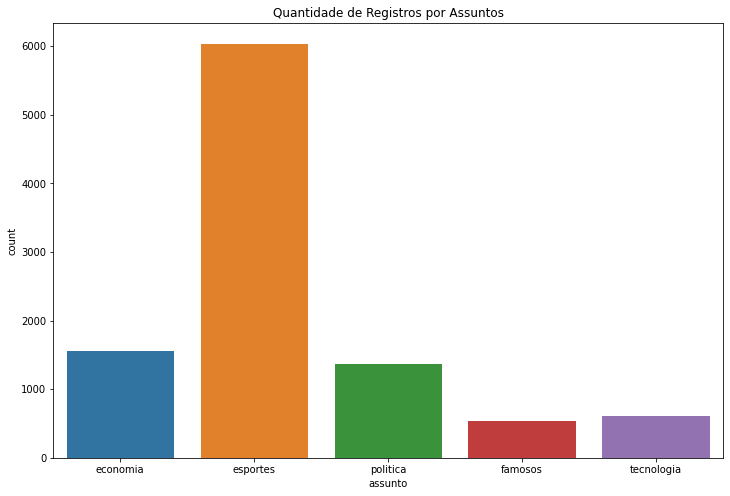

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x = df['assunto']);
plt.title(f'Quantidade de Registros por Assuntos');
plt.savefig('Quantidade de Registros por Assuntos.png')
plt.show()

Base está desbalanceada. Ao longo da modelagem será possível verificar se isso irá impactar o resultado das classificações, de forma a concluir se serão necessárias ações para balanceamento.


Criando uma coluna para registrar o tamanho dos textos das notícias

In [ ]:
df['conteudo_noticia'] = df['conteudo_noticia'].astype(str)
df['text_length'] = df['conteudo_noticia'].apply(len)
df['text_length'].describe()

count    10109.000000
mean      2796.376496
std       2235.861394
min          1.000000
25%       1467.000000
50%       2195.000000
75%       3403.000000
max      32851.000000
Name: text_length, dtype: float64

Verificando o tamanho dos textos das notícias da base e por assunto

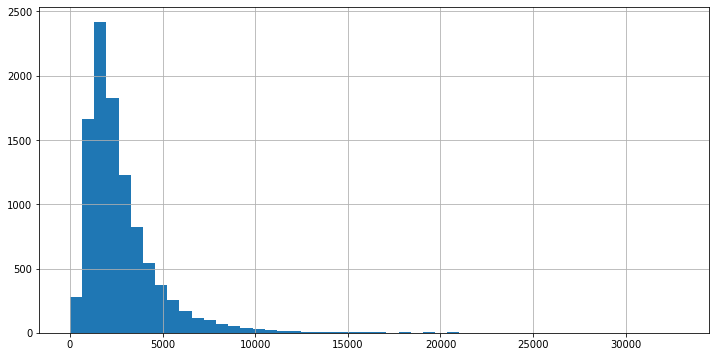

In [ ]:
plt.figure(figsize=(12,6))
df['text_length'].hist(bins=50);
plt.savefig('Tamanho do Texto das Notícias.png')
plt.show()

<Figure size 864x432 with 0 Axes>

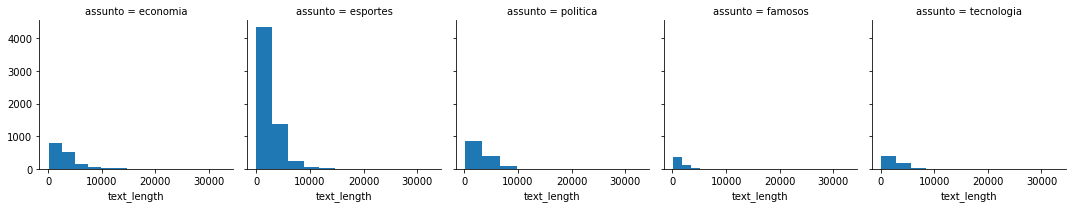

In [ ]:
plt.figure(figsize=(12,6));
g = sns.FacetGrid(df,col='assunto');
g.map(plt.hist,'text_length');
plt.savefig('Tamanho do Texto das Notícias por Assunto.png');
plt.show()

## Pré-processamento:


*   Limpeza dos Dados
*   Verificação dos termos mais frequentes: Wordcloud
*   Divisão da Base de Dados em treino e teste
*   TF-IDF



Limpeza dos dados

In [ ]:
df['clean_conteudo'] = df['conteudo_noticia'].apply(clean_text)
df['clean_conteudo'] = df['clean_conteudo'].apply(deEmojify)

 Termos mais frequentes: Wordcloud

Wordcloud de toda a Base de Notícias

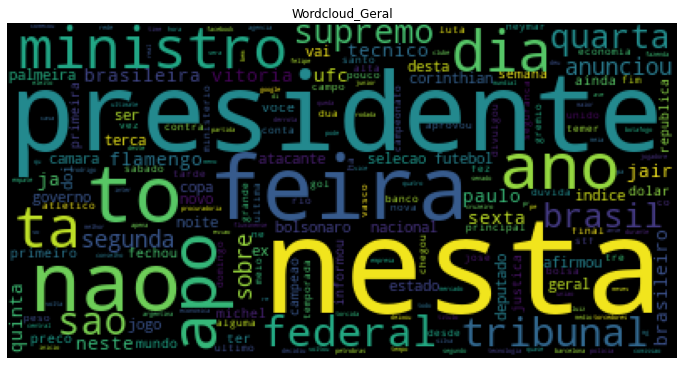

In [ ]:
text = df['clean_conteudo']
assunto_list = []
wordcloud(text,assunto_list)

Wordcloud dos Assuntos

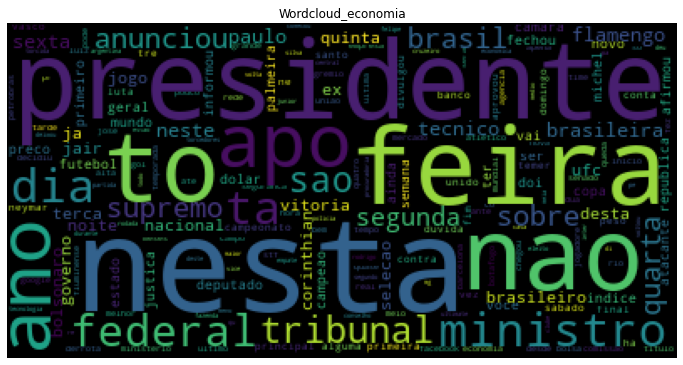

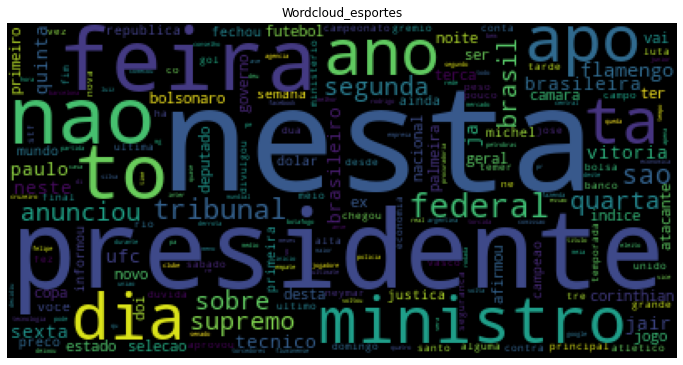

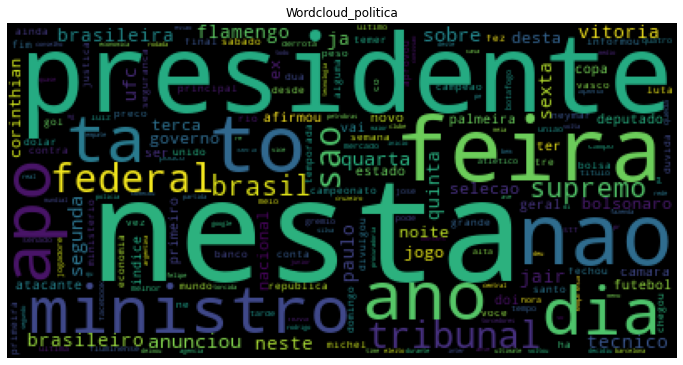

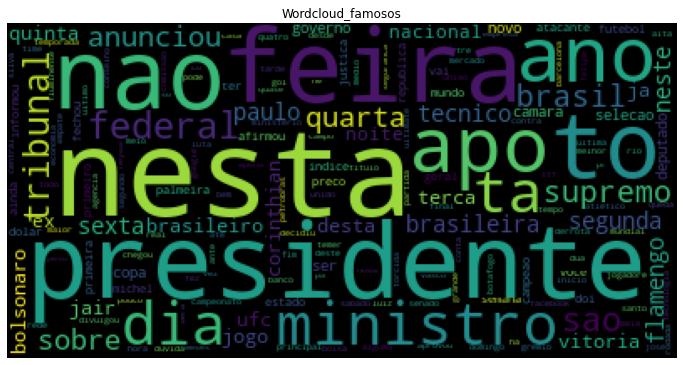

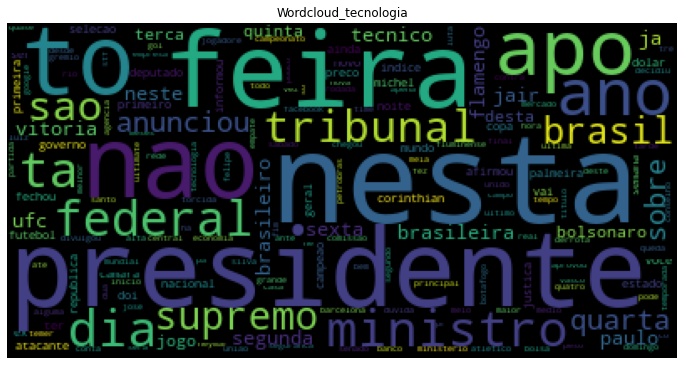

In [ ]:
assunto_list = df['assunto'].unique()
wordcloud(text,assunto_list)

Preparação e Divisão da Base de Dados

In [ ]:
X = df['clean_conteudo']

df['Code'] = df['assunto']
df = df.replace({'Code':dict_classes})

y = df['Code']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8087,) (2022,) (8087,) (2022,)


In [ ]:
# Parameter election
ngram_range = (1,2)
min_df = 15
max_df = 1.
max_features = 5000

Tfidf_vect = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

Tfidf_vect.fit(df['clean_conteudo'])
X_train_Tfidf = Tfidf_vect.transform(X_train).toarray()
X_test_Tfidf = Tfidf_vect.transform(X_test).toarray()

##Modelos

In [ ]:
#Auxiliar para a matrix de confusão
df_aux = df[['assunto', 'Code']].drop_duplicates().sort_values('Code')
classes = df['assunto'].unique()
column='assunto'

### SVM

In [ ]:
SVM = svm.SVC(C=0.1, kernel='linear', degree=3, gamma='auto',probability=True)
predictions_SVM = predict_model(SVM, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

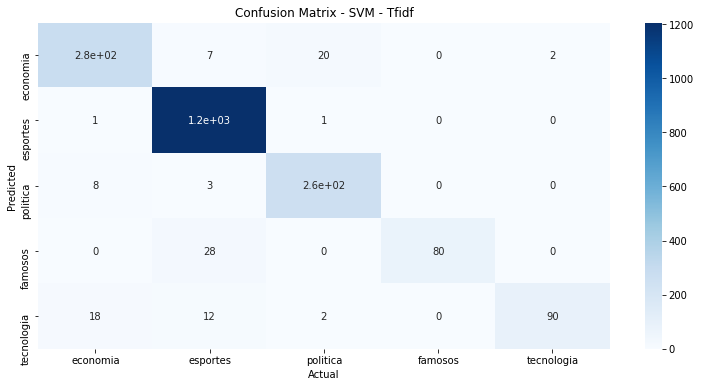

In [ ]:
plot_confusion_matrix('SVM - Tfidf', y_test, predictions_SVM, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_SVM)

Model Performance metrics:
------------------------------
Accuracy: 0.9496
Precision: 0.9506
Recall: 0.9496
F1 Score: 0.9477

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       312
           1       0.96      1.00      0.98      1207
           2       0.92      0.96      0.94       273
           3       1.00      0.74      0.85       108
           4       0.98      0.74      0.84       122

    accuracy                           0.95      2022
   macro avg       0.95      0.87      0.90      2022
weighted avg       0.95      0.95      0.95      2022



###SVM-Balanced

In [ ]:
SVM_balance = svm.SVC(C=0.1, kernel='linear', degree=3, gamma='auto',probability=True, class_weight='balanced')
predictions_SVM_balance = predict_model(SVM_balance, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

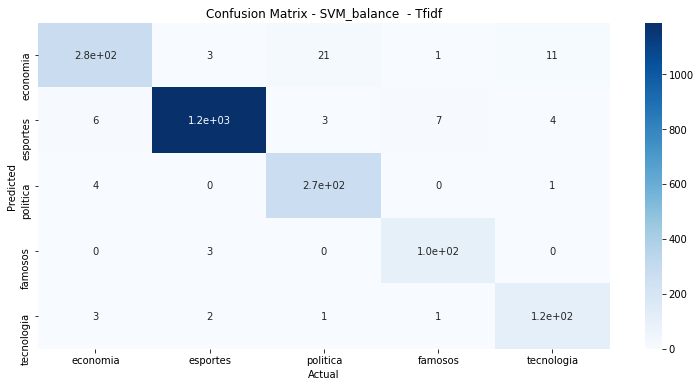

In [ ]:
plot_confusion_matrix('SVM_balance  - Tfidf', y_test, predictions_SVM_balance , df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_SVM_balance)

Model Performance metrics:
------------------------------
Accuracy: 0.9649
Precision: 0.966
Recall: 0.9649
F1 Score: 0.9649

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       312
           1       0.99      0.98      0.99      1207
           2       0.91      0.98      0.95       273
           3       0.92      0.97      0.95       108
           4       0.88      0.94      0.91       122

    accuracy                           0.96      2022
   macro avg       0.93      0.95      0.94      2022
weighted avg       0.97      0.96      0.96      2022



### NB Multinominal

In [ ]:
NB_MN = MultinomialNB()
predictions_NB_MN = predict_model(NB_MN, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

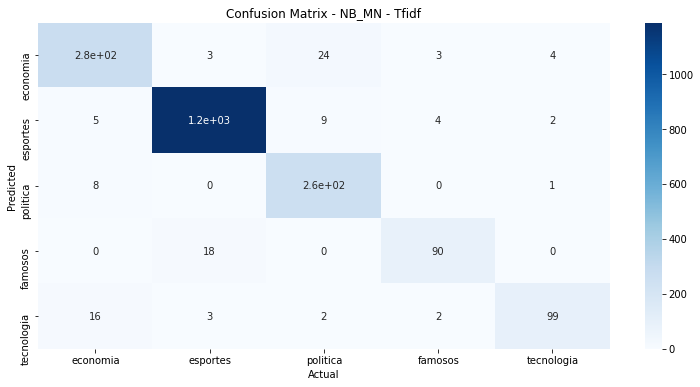

In [ ]:
plot_confusion_matrix('NB_MN - Tfidf', y_test, predictions_NB_MN, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_NB_MN)

Model Performance metrics:
------------------------------
Accuracy: 0.9486
Precision: 0.9489
Recall: 0.9486
F1 Score: 0.9481

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       312
           1       0.98      0.98      0.98      1207
           2       0.88      0.97      0.92       273
           3       0.91      0.83      0.87       108
           4       0.93      0.81      0.87       122

    accuracy                           0.95      2022
   macro avg       0.92      0.90      0.91      2022
weighted avg       0.95      0.95      0.95      2022



###NB Gaussian

In [ ]:
NB = GaussianNB()
predictions_NB = predict_model(NB, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

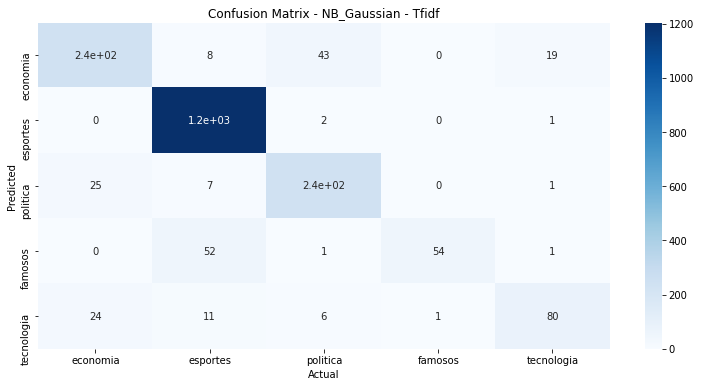

In [ ]:
plot_confusion_matrix('NB_Gaussian - Tfidf', y_test, predictions_NB, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_NB)

Model Performance metrics:
------------------------------
Accuracy: 0.9001
Precision: 0.8997
Recall: 0.9001
F1 Score: 0.8945

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       312
           1       0.94      1.00      0.97      1207
           2       0.82      0.88      0.85       273
           3       0.98      0.50      0.66       108
           4       0.78      0.66      0.71       122

    accuracy                           0.90      2022
   macro avg       0.87      0.76      0.80      2022
weighted avg       0.90      0.90      0.89      2022



### Decision Tree

In [ ]:
DT = DecisionTreeClassifier()
predictions_DT = predict_model(DT, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

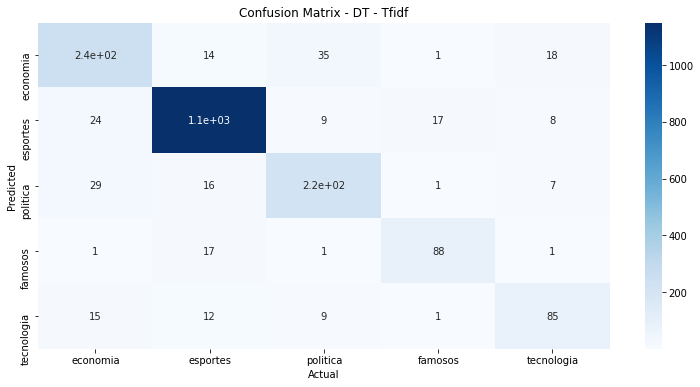

In [ ]:
plot_confusion_matrix('DT - Tfidf', y_test, predictions_DT, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_DT)

Model Performance metrics:
------------------------------
Accuracy: 0.8833
Precision: 0.8831
Recall: 0.8833
F1 Score: 0.8832

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       312
           1       0.95      0.95      0.95      1207
           2       0.80      0.81      0.80       273
           3       0.81      0.81      0.81       108
           4       0.71      0.70      0.71       122

    accuracy                           0.88      2022
   macro avg       0.81      0.81      0.81      2022
weighted avg       0.88      0.88      0.88      2022



### SGD

In [ ]:
SGD = SGDClassifier()
predictions_SGD = predict_model(SGD, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

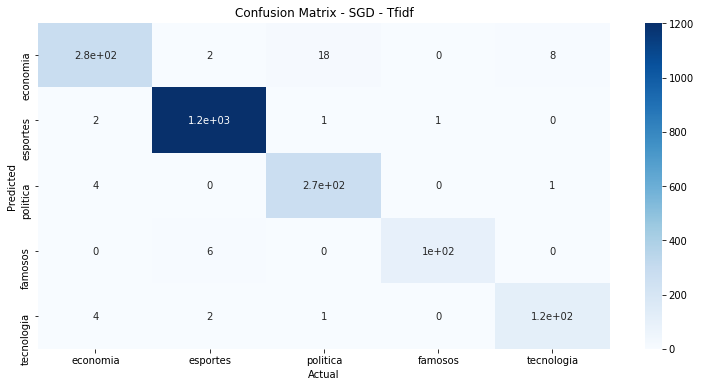

In [ ]:
plot_confusion_matrix('SGD - Tfidf', y_test, predictions_SGD, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_SGD)

Model Performance metrics:
------------------------------
Accuracy: 0.9753
Precision: 0.9756
Recall: 0.9753
F1 Score: 0.9752

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       312
           1       0.99      1.00      0.99      1207
           2       0.93      0.98      0.96       273
           3       0.99      0.94      0.97       108
           4       0.93      0.94      0.93       122

    accuracy                           0.98      2022
   macro avg       0.96      0.96      0.96      2022
weighted avg       0.98      0.98      0.98      2022



###LGBM

In [ ]:
lgbm = LGBMClassifier()
predictions_lgbm = predict_model(lgbm, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

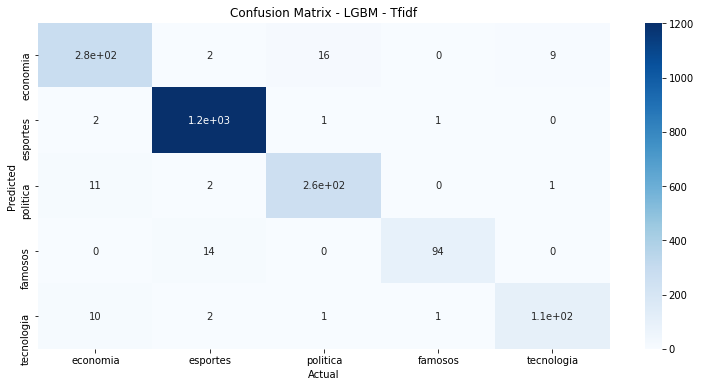

In [ ]:
plot_confusion_matrix('LGBM - Tfidf', y_test, predictions_lgbm, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_lgbm)

Model Performance metrics:
------------------------------
Accuracy: 0.9639
Precision: 0.9637
Recall: 0.9639
F1 Score: 0.9636

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       312
           1       0.98      1.00      0.99      1207
           2       0.94      0.95      0.94       273
           3       0.98      0.87      0.92       108
           4       0.92      0.89      0.90       122

    accuracy                           0.96      2022
   macro avg       0.95      0.92      0.93      2022
weighted avg       0.96      0.96      0.96      2022



###KNN

In [ ]:
KNN = KNeighborsClassifier()
predictions_KNN = predict_model(KNN, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

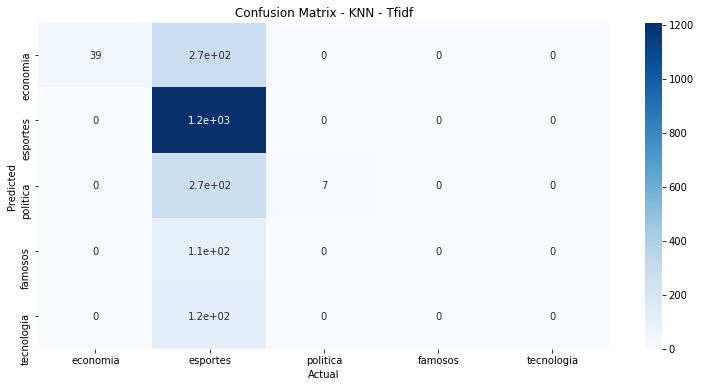

In [ ]:
plot_confusion_matrix('KNN - Tfidf', y_test, predictions_KNN, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_KNN)

Model Performance metrics:
------------------------------
Accuracy: 0.6197
Precision: 0.6539
Recall: 0.6197
F1 Score: 0.4938

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.12      0.22       312
           1       0.61      1.00      0.76      1207
           2       1.00      0.03      0.05       273
           3       0.00      0.00      0.00       108
           4       0.00      0.00      0.00       122

    accuracy                           0.62      2022
   macro avg       0.52      0.23      0.21      2022
weighted avg       0.65      0.62      0.49      2022



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Random Forest

In [ ]:
RF = RandomForestClassifier()
predictions_RF = predict_model(RF, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

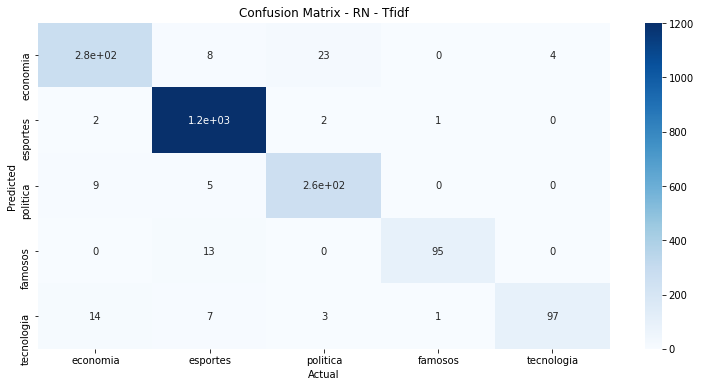

In [ ]:
plot_confusion_matrix('RN - Tfidf', y_test, predictions_RF, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_RF)

Model Performance metrics:
------------------------------
Accuracy: 0.9545
Precision: 0.9546
Recall: 0.9545
F1 Score: 0.9538

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       312
           1       0.97      1.00      0.98      1207
           2       0.90      0.95      0.92       273
           3       0.98      0.88      0.93       108
           4       0.96      0.80      0.87       122

    accuracy                           0.95      2022
   macro avg       0.95      0.90      0.92      2022
weighted avg       0.95      0.95      0.95      2022



###MLP

In [ ]:
MLP = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(68,68), verbose=True)
predictions_MLP = predict_model(MLP, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

Iteration 1, loss = 1.06786456
Iteration 2, loss = 0.32702211
Iteration 3, loss = 0.12735206
Iteration 4, loss = 0.06630571
Iteration 5, loss = 0.04021646
Iteration 6, loss = 0.02620964
Iteration 7, loss = 0.01710931
Iteration 8, loss = 0.01160544
Iteration 9, loss = 0.00795425
Iteration 10, loss = 0.00578033
Iteration 11, loss = 0.00434333
Iteration 12, loss = 0.00339358
Iteration 13, loss = 0.00274312
Iteration 14, loss = 0.00224735
Iteration 15, loss = 0.00187327
Iteration 16, loss = 0.00158496
Iteration 17, loss = 0.00136164
Iteration 18, loss = 0.00118022
Iteration 19, loss = 0.00103103
Iteration 20, loss = 0.00091057
Iteration 21, loss = 0.00080378
Iteration 22, loss = 0.00071939
Iteration 23, loss = 0.00064688
Iteration 24, loss = 0.00058403
Iteration 25, loss = 0.00053158
Iteration 26, loss = 0.00048472
Iteration 27, loss = 0.00044044
Iteration 28, loss = 0.00040405
Iteration 29, loss = 0.00037315
Iteration 30, loss = 0.00034584
Iteration 31, loss = 0.00032096
Iteration 32, los

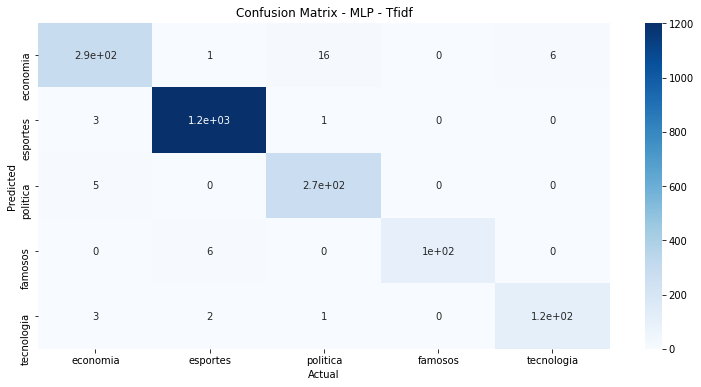

In [ ]:
plot_confusion_matrix('MLP - Tfidf', y_test, predictions_MLP, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_MLP)

Model Performance metrics:
------------------------------
Accuracy: 0.9782
Precision: 0.9784
Recall: 0.9782
F1 Score: 0.9782

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       312
           1       0.99      1.00      0.99      1207
           2       0.94      0.98      0.96       273
           3       1.00      0.94      0.97       108
           4       0.95      0.95      0.95       122

    accuracy                           0.98      2022
   macro avg       0.97      0.96      0.96      2022
weighted avg       0.98      0.98      0.98      2022



###MLP - Outra Configuração

In [ ]:
MLP_2 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(48,48), verbose=True)
predictions_MLP2 = predict_model(MLP_2, X_train_Tfidf, y_train, X_test_Tfidf, y_test)

Iteration 1, loss = 1.16622626
Iteration 2, loss = 0.49296982
Iteration 3, loss = 0.20960060
Iteration 4, loss = 0.10485214
Iteration 5, loss = 0.06562948
Iteration 6, loss = 0.04447687
Iteration 7, loss = 0.03142573
Iteration 8, loss = 0.02159868
Iteration 9, loss = 0.01554879
Iteration 10, loss = 0.01119929
Iteration 11, loss = 0.00818192
Iteration 12, loss = 0.00626538
Iteration 13, loss = 0.00499583
Iteration 14, loss = 0.00403048
Iteration 15, loss = 0.00335095
Iteration 16, loss = 0.00283481
Iteration 17, loss = 0.00241569
Iteration 18, loss = 0.00209826
Iteration 19, loss = 0.00183740
Iteration 20, loss = 0.00162054
Iteration 21, loss = 0.00144033
Iteration 22, loss = 0.00128795
Iteration 23, loss = 0.00114574
Iteration 24, loss = 0.00103274
Iteration 25, loss = 0.00093385
Iteration 26, loss = 0.00085116
Iteration 27, loss = 0.00077172
Iteration 28, loss = 0.00070729
Iteration 29, loss = 0.00064779
Iteration 30, loss = 0.00059673
Iteration 31, loss = 0.00055260
Iteration 32, los

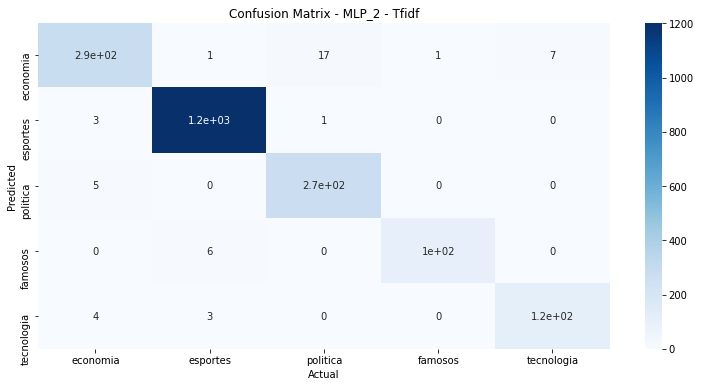

In [ ]:
plot_confusion_matrix('MLP_2 - Tfidf', y_test, predictions_MLP2, df_aux,column)

In [ ]:
model_performance_metrics(y_test, predictions_MLP2)

Model Performance metrics:
------------------------------
Accuracy: 0.9763
Precision: 0.9764
Recall: 0.9763
F1 Score: 0.9761

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       312
           1       0.99      1.00      0.99      1207
           2       0.94      0.98      0.96       273
           3       0.99      0.94      0.97       108
           4       0.94      0.94      0.94       122

    accuracy                           0.98      2022
   macro avg       0.96      0.96      0.96      2022
weighted avg       0.98      0.98      0.98      2022



##Conclusão e Seleção do Modelo

**O desbalanceamento da base não causou prejuízo no resultado final. O modelo escolhido foi o MLP pois apresentou as melhores métricas.**

Salvando Modelo

In [ ]:
model = MLP
model_name = 'MLP'
model_save(model, model_name)

Carregando o Modelo e Verificando Métricas

In [ ]:
modelo = load_model(model_name)

In [ ]:
predictions_model = predictions_MLP
model_performance_metrics(y_test, predictions_model)

Model Performance metrics:
------------------------------
Accuracy: 0.9782
Precision: 0.9784
Recall: 0.9782
F1 Score: 0.9782

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       312
           1       0.99      1.00      0.99      1207
           2       0.94      0.98      0.96       273
           3       1.00      0.94      0.97       108
           4       0.95      0.95      0.95       122

    accuracy                           0.98      2022
   macro avg       0.97      0.96      0.96      2022
weighted avg       0.98      0.98      0.98      2022

